In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import random
import pickle


file_list = []
class_list = []

DATADIR = "data"

# All the categories you want your neural network to detect
CATEGORIES = ["Botella", "Lata", "Tetrapak"]

# The size of the images that your neural network will use
IMG_SIZE = 64

# Checking or all images in the data folder
for category in CATEGORIES :
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

training_data = []

def create_training_data():
    for category in CATEGORIES :
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

random.shuffle(training_data)

X = [] #features
y = [] #labels

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Creating the files containing all the information about your model
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

In [2]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Opening the files about data
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

# normalizing data (a pixel goes from 0 to 255)
X = X/255.0
y = np.array(y)

# Building the model
model = Sequential()
# 3 convolutional layers
model.add(Conv2D(32, (3, 3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 hidden layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))

model.add(Dense(128))
model.add(Activation("relu"))

# The output layer with 3 neurons, for 3 classes
model.add(Dense(3))
model.add(Activation("softmax"))

# Compiling the model using some basic parameters
model.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

# Training the model, with 40 iterations
# validation_split corresponds to the percentage of images used for the validation phase compared to all the images
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.3)

# Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file :
	json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

model.save('CNN.model')

Epoch 1/10
53/53 [==============================] - 12s 224ms/step - loss: 0.9847 - accuracy: 0.5006 - val_loss: 0.7071 - val_accuracy: 0.6264
Epoch 2/10
53/53 [==============================] - 9s 166ms/step - loss: 0.5617 - accuracy: 0.7351 - val_loss: 0.3936 - val_accuracy: 0.8458
Epoch 3/10
53/53 [==============================] - 7s 136ms/step - loss: 0.3307 - accuracy: 0.8714 - val_loss: 0.1823 - val_accuracy: 0.9431
Epoch 4/10
53/53 [==============================] - 7s 138ms/step - loss: 0.1650 - accuracy: 0.9429 - val_loss: 0.0740 - val_accuracy: 0.9792
Epoch 5/10
53/53 [==============================] - 7s 139ms/step - loss: 0.1059 - accuracy: 0.9583 - val_loss: 0.0804 - val_accuracy: 0.9694
Epoch 6/10
53/53 [==============================] - 7s 137ms/step - loss: 0.0730 - accuracy: 0.9768 - val_loss: 0.0726 - val_accuracy: 0.9694
Epoch 7/10
53/53 [==============================] - 7s 136ms/step - loss: 0.0556 - accuracy: 0.9768 - val_loss: 0.0325 - val_accuracy: 0.9889
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


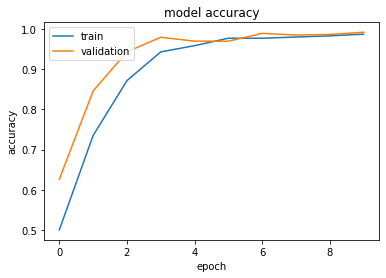

In [4]:
# Printing a graph showing the accuracy changes during the training phase
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


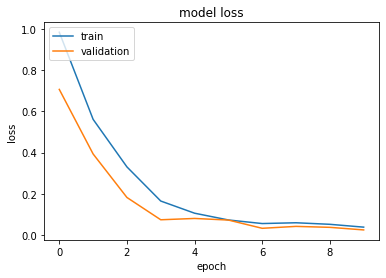

In [5]:
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [6]:
def decode_onehot(tensor):
    decoded = []
    for prediction in tensor:
        m = 0
        k = 0
        for j in range(len(tensor[0])):
            if prediction[j] > m:
                m = prediction[j]
                k = j
        decoded.append(k)
    return np.array(decoded)

In [7]:
y_pred = decode_onehot(model.predict(X_test))

In [8]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [9]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalized=True,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Matriz de confusion normalizada'
        fmt = '.2f'
    else:
        title='Matriz de confusion no normalizada'
        fmt = 'd'
        
    plt.figure(figsize=(8, 6), dpi=90)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid('off')
    plt.tight_layout()

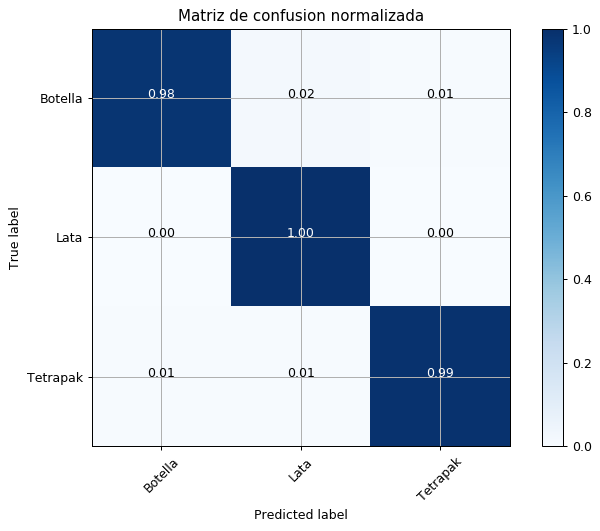

In [10]:
plot_confusion_matrix(cm, CATEGORIES, normalized=True)

In [17]:
X_test[0].shape

(64, 64, 1)

In [27]:
def show_img_results(classifier, X, y, n_img): # Toma n imagenes, las muestra con su clase verdadera y predecida.
    img = X[n_img]
    plt.imshow(img.squeeze())
    gold = y[n_img]
    print('Clase Real: ', gold)
    pred = decode_onehot(classifier.predict(np.array([X[n_img]])))[0]
    print('Clase Predicha. ', pred)

Clase Real:  0
Clase Predicha.  0


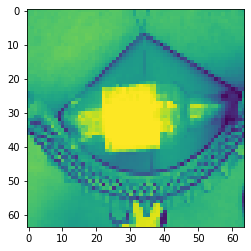

In [61]:
show_img_results(model, X_test, y_test, 193)

Clase Real:  1
Clase Predicha.  1


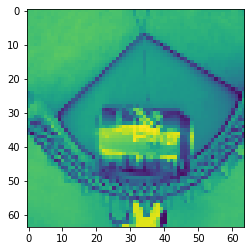

In [64]:
show_img_results(model, X_test, y_test, 194)

In [65]:
def show_misclassifications(classifier, Data, label):
    for i in range(len(Data)):
        gold = y[i]
        pred = decode_onehot(classifier.predict(np.array([X[i]])))[0]
        if gold != pred:
            print(i)
            print('Clase Real: ', gold)
            print('Clase Predicha: ', pred)
            img = X[i]
            plt.figure()
            plt.imshow(img.squeeze())
            plt.show()

193
Clase Real:  2
Clase Predicha:  1


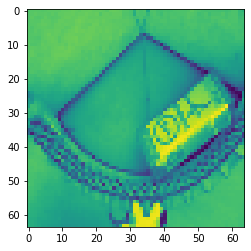

194
Clase Real:  2
Clase Predicha:  1


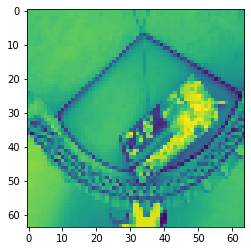

424
Clase Real:  0
Clase Predicha:  1


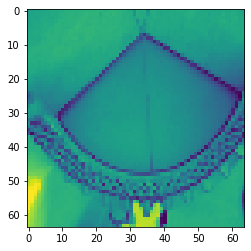

In [66]:
show_misclassifications(model, X_test, y_test)